In [1]:
from vivarium import Artifact
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from db_queries import get_ids, get_outputs
import scipy.stats
from get_draws.api import get_draws

In [2]:
output_dirs = ['/share/costeffectiveness/results/vivarium_conic_lsff/00_bugfix/25draw_5seed/india/2020_06_19_18_11_00/count_data/']

locations = ['India']

# Validate anemia prevalence using anemia impairment prevalence from GBD

In [36]:
# get simulation anemia prevalence

anemia_prev = pd.DataFrame()
for i in range(len(output_dirs)):
    anemia_pt = pd.read_hdf(output_dirs[i] + 'anemia_state_person_time.hdf')
    anemia_pt = anemia_pt.groupby(['input_draw','age_group','sex','scenario','measure']).sum()
    pt = pd.read_hdf(output_dirs[i] + 'person_time.hdf')
    pt = pt.groupby(['input_draw','age_group','sex','scenario']).sum()
    prev = anemia_pt / pt
    prev = prev.reset_index()
    prev['location'] = locations[i]
    anemia_prev = anemia_prev.append(prev)
    anemia_prev = anemia_prev.rename(columns={'measure':'severity'})
    anemia_prev['measure'] = 'prevalence'
anemia_prev.head()

,input_draw,age_group,sex,scenario,severity,value,location,measure
0,21,1_to_4,female,baseline,anemia_mild,0.303132,India,prevalence
1,21,1_to_4,female,baseline,anemia_moderate,0.332824,India,prevalence
2,21,1_to_4,female,baseline,anemia_none,0.348016,India,prevalence
3,21,1_to_4,female,baseline,anemia_severe,0.015474,India,prevalence
4,21,1_to_4,female,folic_acid_fortification_scale_up,anemia_mild,0.303448,India,prevalence


In [38]:
# get simulation anemia YLD rate

anemia_ylds = pd.DataFrame()
for i in range(len(output_dirs)):
    ylds = pd.read_hdf(output_dirs[i] + 'ylds.hdf')
    ylds_anemia = ylds.loc[ylds.cause == 'iron_deficiency']
    ylds_anemia = ylds_anemia.groupby(['input_draw','age_group','sex','scenario']).sum()
    pt = pd.read_hdf(output_dirs[i] + 'person_time.hdf')
    pt = pt.groupby(['input_draw','age_group','sex','scenario']).sum()
    anemia_yld_rate = ylds_anemia / pt
    anemia_yld_rate = anemia_yld_rate.reset_index()
    anemia_yld_rate['location'] = locations[i]
    anemia_ylds = anemia_ylds.append(anemia_yld_rate)
    anemia_ylds['measure'] = 'ylds'
    anemia_ylds['severity'] = 'anemia_total'
anemia_ylds.head()

,input_draw,age_group,sex,scenario,value,location,measure,severity
0,21,1_to_4,female,baseline,0.023998,India,ylds,anemia_total
1,21,1_to_4,female,folic_acid_fortification_scale_up,0.023993,India,ylds,anemia_total
2,21,1_to_4,female,iron_folic_acid_fortification_scale_up,0.023977,India,ylds,anemia_total
3,21,1_to_4,female,iron_fortification_scale_up,0.024028,India,ylds,anemia_total
4,21,1_to_4,female,vitamin_a_fortification_scale_up,0.023998,India,ylds,anemia_total


In [65]:
# combine model prevalence and ylds

anemia_model = anemia_prev.append(anemia_ylds)
anemia_model = anemia_model.loc[anemia_model.scenario == 'baseline']
anemia_model = anemia_model.sort_values(by=['location','measure','severity','sex','age_group'])
anemia_model.head()

,age_group,input_draw,location,measure,scenario,severity,sex,value
0,1_to_4,21,India,prevalence,baseline,anemia_mild,female,0.303132
160,1_to_4,29,India,prevalence,baseline,anemia_mild,female,0.299706
320,1_to_4,55,India,prevalence,baseline,anemia_mild,female,0.294879
480,1_to_4,78,India,prevalence,baseline,anemia_mild,female,0.293796
640,1_to_4,155,India,prevalence,baseline,anemia_mild,female,0.293525


In [67]:
anemia_model_mean = anemia_model.groupby(['age_group','location','measure','severity','sex']).mean().reset_index()
anemia_model_mean.head()

,age_group,location,measure,severity,sex,input_draw,value
0,1_to_4,India,prevalence,anemia_mild,female,437.52,0.300535
1,1_to_4,India,prevalence,anemia_mild,male,437.52,0.298527
2,1_to_4,India,prevalence,anemia_moderate,female,437.52,0.354920
3,1_to_4,India,prevalence,anemia_moderate,male,437.52,0.361200
4,1_to_4,India,prevalence,anemia_none,female,437.52,0.326131


In [84]:
# get global anemia impairment prevalence and YLD rate from GBD

gbd_anemia = get_draws('rei_id', [192,205,206,207], source='como', measure_id=[3,5], location_id=[163], 
                   year_id=2017, gbd_round_id=5, age_group_id=[2,3,4,5])
gbd_anemia = gbd_anemia.loc[gbd_anemia.cause_id == 294]
gbd_anemia = gbd_anemia.set_index(['age_group_id','location_id', 'measure_id', 'rei_id',
                                 'sex_id', 'year_id', 'metric_id','cause_id'])

# get means and LCLs, UCLs
gbd = (gbd_anemia.apply(pd.DataFrame.describe, percentiles=[0.025,0.975], axis=1)
       .drop(columns=['count','std','min','max','50%'])
       .rename(columns={'2.5%':'lower','97.5%':'upper'}).reset_index())

# rename variables for compatibility
gbd['age_group'] = 0
gbd['age_group'] = np.where(gbd['age_group_id'] == 2, 'early_neonatal', 
                           np.where(gbd['age_group_id'] == 3, 'late_neonatal',
                                    np.where(gbd['age_group_id'] == 4, 'post_neonatal', 
                                            '1_to_4')))
gbd['sex'] = np.where(gbd['sex_id'] == 1, 'male', 'female')
gbd['anemia_group'] = np.where(gbd['rei_id'] == 205, 'anemia_mild', 
                               np.where(gbd['rei_id'] == 206, 'anemia_moderate',
                                        np.where(gbd['rei_id'] == 207, 'anemia_severe', 'anemia_total')))
gbd['location'] = np.where(gbd['location_id'] == 163, 'India',
                          np.where(gbd['location_id'] == 214, 'Nigeria', 'Ethiopia'))
gbd['measure'] = np.where(gbd['measure_id'] == 3, 'ylds', 'prevalence')
gbd = gbd.rename(columns={'anemia_group':'severity'})
gbd = gbd.drop(columns=['age_group_id','location_id','rei_id','sex_id','measure_id','metric_id'])
gbd.head()

,year_id,cause_id,mean,lower,upper,age_group,sex,severity,location,measure
0,2017,294,0.026172,0.016666,0.039066,early_neonatal,male,anemia_total,India,ylds
1,2017,294,0.001010,0.000358,0.002242,early_neonatal,male,anemia_mild,India,ylds
2,2017,294,0.020791,0.013063,0.031267,early_neonatal,male,anemia_moderate,India,ylds
3,2017,294,0.004371,0.002666,0.006530,early_neonatal,male,anemia_severe,India,ylds
4,2017,294,0.026141,0.016349,0.038769,late_neonatal,male,anemia_total,India,ylds


In [86]:
anemia_gbd = gbd.sort_values(by=['location','measure','severity','sex','age_group'])
anemia_gbd.head()

,year_id,cause_id,mean,lower,upper,age_group,sex,severity,location,measure
61,2017,294,0.275081,0.257035,0.297052,1_to_4,female,anemia_mild,India,prevalence
49,2017,294,0.270099,0.214598,0.309470,early_neonatal,female,anemia_mild,India,prevalence
53,2017,294,0.269910,0.209978,0.312618,late_neonatal,female,anemia_mild,India,prevalence
57,2017,294,0.269665,0.228673,0.301790,post_neonatal,female,anemia_mild,India,prevalence
45,2017,294,0.271636,0.254649,0.290653,1_to_4,male,anemia_mild,India,prevalence


In [87]:
for data_set in [anemia_model, anemia_model_mean, anemia_gbd]:
    data_set['age_group_order'] = np.where(data_set['age_group'] == 'early_neonatal', 1,
                                          np.where(data_set['age_group'] == 'late_neonatal', 2,
                                                  np.where(data_set['age_group'] == 'post_neonatal', 3,
                                                          np.where(data_set['age_group'] == '1_to_4', 4, 0))))
    
anemia_model = anemia_model.set_index(['location','severity','sex','age_group_order']).sort_index().reset_index()
anemia_model_mean = anemia_model_mean.set_index(['location','severity','sex','age_group_order']).sort_index().reset_index()
anemia_gbd = anemia_gbd.set_index(['location','severity','sex','age_group_order']).sort_index().reset_index()

In [71]:
severity_list = ['anemia_mild','anemia_moderate','anemia_severe','anemia_total']

def make_multiple_plots(severity_list):
    for severity in severity_list:
        if severity == 'anemia_total':
            plot_measures = ['ylds']
        else:
            plot_measures = ['prevalence']
        for measure in plot_measures:
            
            measure_s = anemia_model.loc[anemia_model.severity == severity]
            measure_s = measure_s.loc[measure_s.measure == measure]
            
            measure_mean = anemia_model_mean.loc[anemia_model_mean.severity == severity]
            measure_m = measure_mean.loc[measure_mean.measure == measure]
            
            measure_gbd = anemia_gbd.loc[anemia_gbd.severity == severity]
            measure_g = measure_gbd.loc[measure_gbd.measure == measure]
        
                
            fig, ax = plt.subplots(figsize=(20, 10))
            clrs = sns.color_palette('husl', 2)

            g1 = sns.catplot(x='age_group', y='value', hue='sex', ax=ax, data=measure_s, 
                             palette=clrs)
            
            sns.lineplot(x='age_group', y='mean', hue='sex', palette=clrs, 
                         linewidth=2, ax=ax, data=measure_g, sort=False)
            
            for i, sex in enumerate(['female','male']):
                sex_g = measure_g.loc[measure_g.sex == sex]
                ax.fill_between(sex_g.age_group.values, sex_g.upper, sex_g.lower, alpha=0.3, label='GBD 95% CI', facecolor=clrs[i])
                
                sex_m = measure_m.loc[measure_m.sex == sex]
                ax.scatter(sex_m.age_group, sex_m.value, s=250, marker='P', 
                       label=f'Sim {sex} mean', c=clrs[i])


            ax.set_title(f'India, {measure.capitalize()} due to {severity.capitalize()}', fontsize=20)
            ax.set_xlabel('Age group', fontsize=18)
    
            l = ax.legend(loc=(1.02, 0.05), fontsize=12)
            labels = ['Sim draws']
            for text, label in zip(l.texts[1:5], labels):
                text.set_text(label)

            plt.close(g1.fig)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

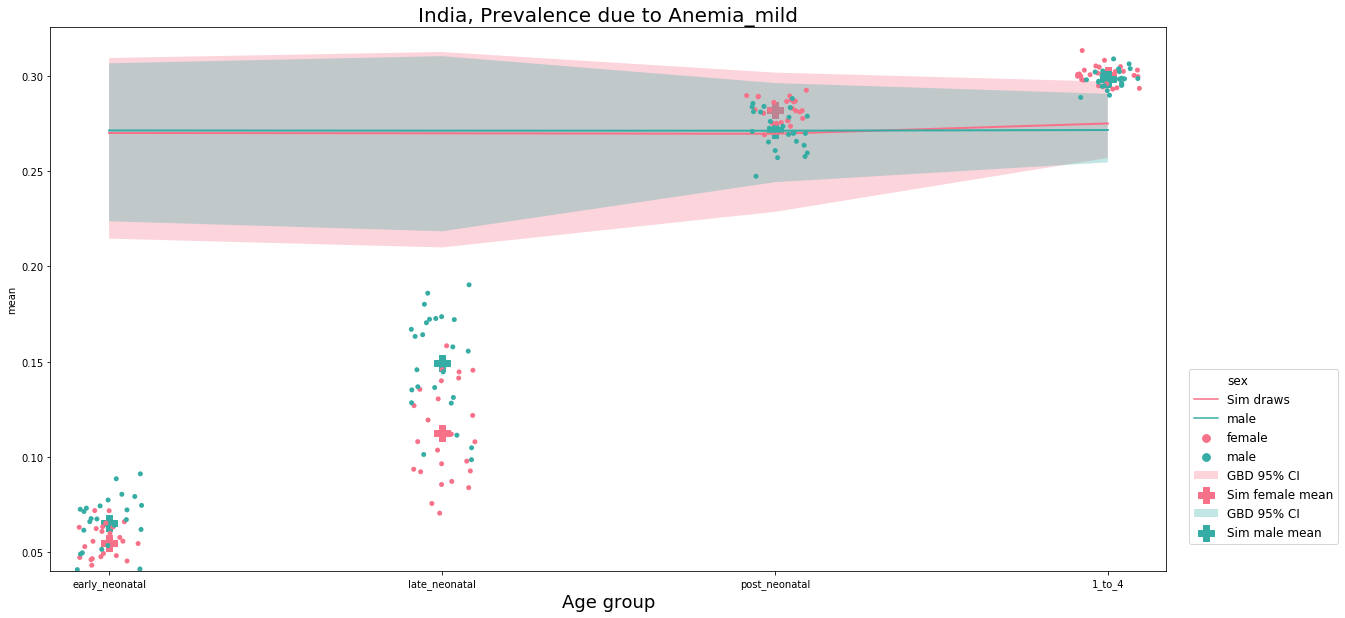

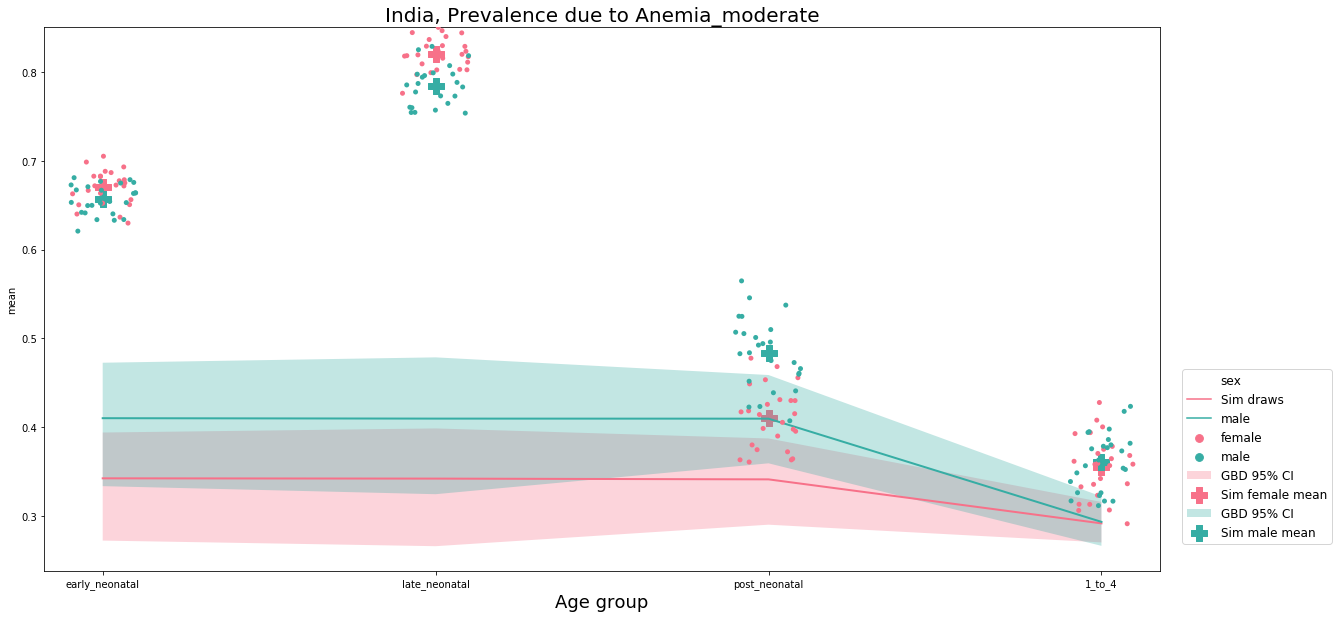

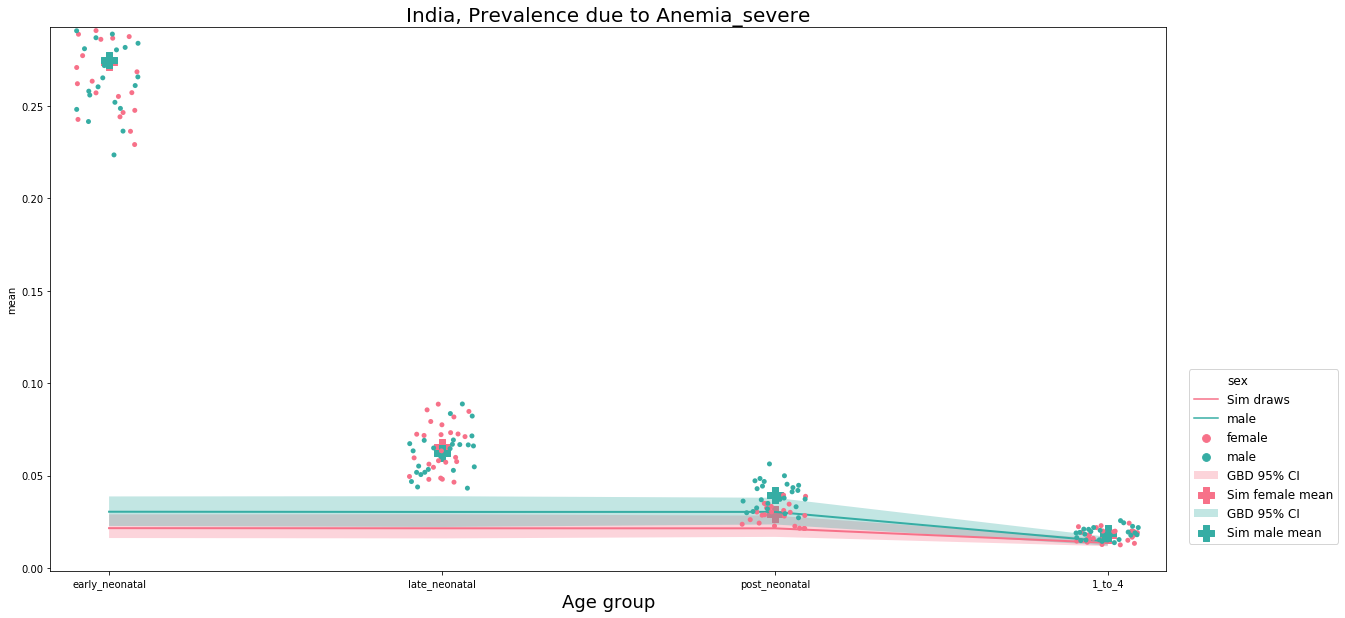

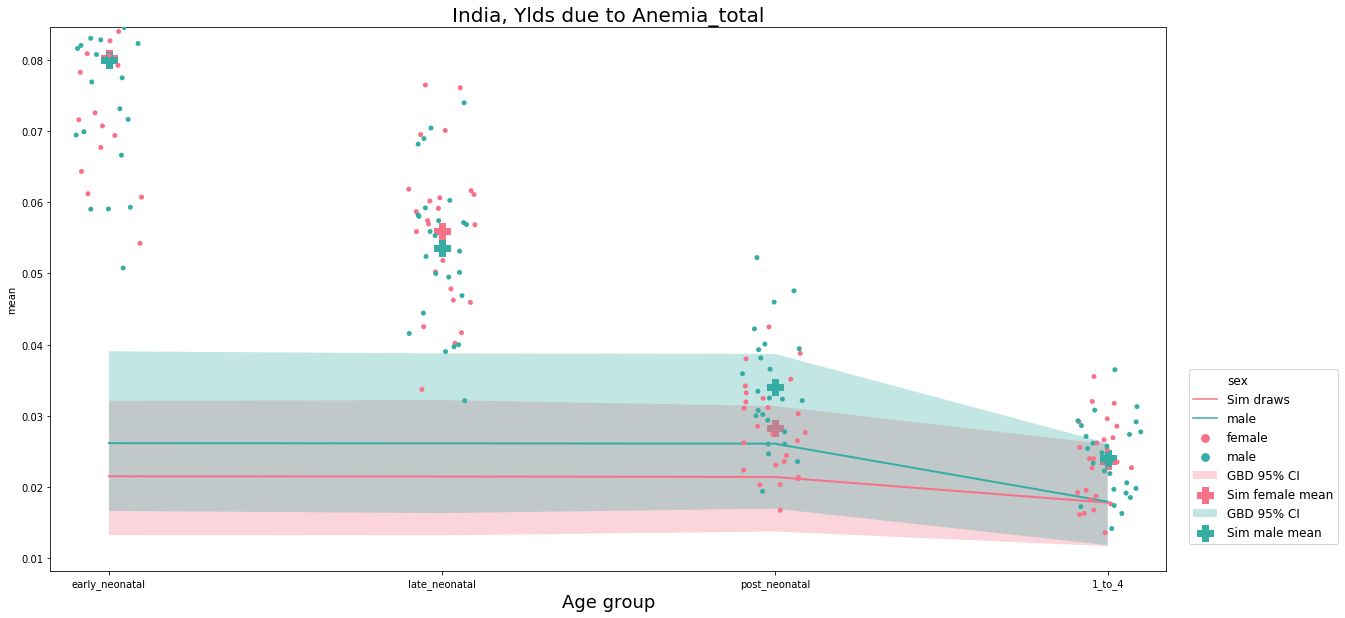

In [89]:
make_multiple_plots(severity_list)

# Conclusions

Early and late neonatal age groups are not validating well, but this is expected and will not influence our model results because the iron fortification intervention does not affect these age groups

We are slightly overestimating anemia prevalence at each severity level, although the overall YLDs due to anemia are within the range of the GBD estimates (although at the high end of the range)